<a href="https://colab.research.google.com/github/juanigp/Toy-Vision-Transformer/blob/main/Toy_ViT_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple implementation of a Vision Transformer model

In [1]:
from math import sqrt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
import matplotlib.pyplot as plt

class MultiheadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        #we can save ourselves the last projection from  num_heads * attention_head_size
        #to hidden_size if hidden_size is a multiple of num_heads
        assert (hidden_size % num_heads) == 0, "hidden_size should be a multiple of num_heads!"
        super().__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.attention_head_size = self.hidden_size // self.num_heads
        #seems redundant, but in a general case, all_heads_size might be different than hidden_size
        self.all_heads_size = self.attention_head_size * self.num_heads
        #we can compute q,k,v as if we had a single attention head of hidden_size
        #instead of num_heads heads and attention_head_size dimensions
        #(but then we should reshape accordingly)
        self.query_layer = nn.Linear(self.hidden_size, self.all_heads_size, bias = False)
        self.key_layer = nn.Linear(self.hidden_size, self.all_heads_size, bias = False)
        self.value_layer = nn.Linear(self.hidden_size, self.all_heads_size, bias = False)
        
    """
    function to reshape the tensors of shape (batch_size, seq_length, hidden_size)
    to (batch_size, num_heads, seq_length, attention_head_size)
    """
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, x):
        query = self.transpose_for_scores(self.query_layer(x))
        key = self.transpose_for_scores(self.key_layer(x) )
        value = self.transpose_for_scores(self.value_layer(x))
        attention_weights = torch.matmul(query, key.transpose(-1,-2)) / sqrt(self.attention_head_size)
        attention_weights = nn.functional.softmax(attention_weights, dim = -1)
        msa_out = torch.matmul(attention_weights, value)
        msa_out = msa_out.permute(0, 2, 1, 3).contiguous()
        new_msa_out_shape = msa_out.size()[:-2] + (self.all_heads_size,)
        msa_out = msa_out.view(*new_msa_out_shape)
        return msa_out

#each encoder layer with the residual connection and layer norms
#plus the projection of hidden_size to bigger dimensionality and back
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, intermediate_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.intermediate_size = intermediate_size
        
        self.fcn = nn.Sequential(
            nn.Linear(self.hidden_size, self.intermediate_size),
            nn.ReLU(),
            nn.Linear(self.intermediate_size, self.hidden_size)
            )
        self.msa = MultiheadSelfAttention(self.hidden_size, self.num_heads)
        self.ln_1 = nn.LayerNorm(hidden_size)
        self.ln_2 = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        x = self.ln_1(x + self.msa(x))
        x = self.ln_2(x + self.fcn(x))
        return x

#extraction and encoding of patches, using a conv2d layer as sliding window and
#linear projection!
class PatchEmbeddings(nn.Module):
    def __init__(self, input_size = (3, 224, 224), patch_size = (16,16), embed_dim = 384):
        super().__init__()
        self.input_size = input_size
        img_size = self.input_size[1:]
        num_channels = input_size[0]
        self.patch_size = patch_size
        self.num_patches = img_size[0] // patch_size[0] * img_size[1] // patch_size[1]
        self.projection = nn.Conv2d(
            num_channels, 
            embed_dim, 
            kernel_size = patch_size, 
            stride = patch_size)
        
        self.only_unroll = False
        if self.patch_size[0]*self.patch_size[1]*num_channels == embed_dim: 
            self.only_unroll = True
        
    def forward(self, x):
        if self.only_unroll:
            embeds = x.view(x.shape[0], self.num_patches,-1)
        else:
            embeds = self.projection(x)
            embeds = embeds.flatten(2).permute(0,2,1)
        return embeds

#feature extractor
class ViTBackbone(nn.Module):
    def __init__(
        self, 
        input_size = (3, 224, 224), 
        patch_size = (16,16),
        hidden_size = 384,
        num_encoder_layers = 12,
        num_heads = 6,
        intermediate_size = 384*4 ):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(input_size, patch_size, hidden_size)
        num_patches = self.patch_embeddings.num_patches
        self.pos_embedding = nn.Parameter(torch.normal(0, 0.2, size=(1, num_patches + 1, hidden_size)))
        self.cls_token = nn.Parameter(torch.normal(0, 0.2, size=(1, 1, hidden_size))) 
        #print(self.cls_token)   
        encoder_layers = []
        for i in range(num_encoder_layers):
            encoder_layers.append(EncoderLayer(hidden_size, num_heads, intermediate_size))
        self.encoder = nn.Sequential(*encoder_layers)
    
    def prepare_sequence(self, x):
        x = self.patch_embeddings(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim = 1)
        x = x + self.pos_embedding
        return x
        
    def forward(self, x):
        x = self.prepare_sequence(x)
        x = self.encoder(x)
        return x

#feature extractor + classifier head
class ViTClassifier(nn.Module):
    def __init__(
        self,
        input_size = (3, 224, 224), 
        patch_size = (16,16),
        hidden_size = 384,
        num_encoder_layers = 12,
        num_heads = 6,
        intermediate_size = 384*4,
        num_classes = 1000 ):
        
        super().__init__()
        self.backbone = ViTBackbone(
            input_size,
            patch_size,
            hidden_size,
            num_encoder_layers,
            num_heads,
            intermediate_size,
        )
        self.fcn = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        cls_token = x[:,0]
        x = self.fcn(cls_token)
        return x


#code from timm's vision models library, useful for calculating metrics!
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

## Training loop

In [2]:
batch_size = 2048
lr = 1e-3
epochs = 100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('./data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('./data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size = batch_size)

model = ViTClassifier(
    input_size = (1,28,28), 
    patch_size = (4,4), 
    hidden_size = 8,
    intermediate_size = 16,
    num_heads = 2,
    num_encoder_layers = 4,
    num_classes = 10)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

model.cuda()
for epoch in range(epochs):
    model.train()
    train_loss_m = AverageMeter()
    test_loss_m = AverageMeter()
    acc_m = AverageMeter()
    for i, batch in enumerate(train_loader):
        samples = batch[0].cuda()
        labels = batch[1].cuda()
        out = model(samples).cuda()
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_m.update(loss.item(), samples.size(0))
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            samples = batch[0].cuda()
            labels = batch[1].cuda()
            out = model(samples).cuda()
            loss = loss_fn(out, labels)
            test_loss_m.update(loss.item(), samples.size(0))
            acc = accuracy(out, labels)[0]
            acc_m.update(acc.item(), samples.size(0))    
    print('epoch {}, train loss: {}, test loss: {}, acc: {}'
          .format(epoch, train_loss_m.avg, test_loss_m.avg, acc_m.avg) )
    


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


epoch 0, train loss: 2.3273069574991863, test loss: 2.278104015350342, acc: 18.500000128173827
epoch 1, train loss: 2.2430899921417238, test loss: 2.2082563678741454, acc: 20.71999998474121
epoch 2, train loss: 2.1637440949757893, test loss: 2.1202776062011717, acc: 23.05000004577637
epoch 3, train loss: 2.0766898375193277, test loss: 2.0159685842514037, acc: 28.249999963378905
epoch 4, train loss: 1.921082757059733, test loss: 1.7673834163665771, acc: 39.73999964599609
epoch 5, train loss: 1.6673765220006307, test loss: 1.575647682762146, acc: 46.89999998779297
epoch 6, train loss: 1.5066710308710733, test loss: 1.4330139678955078, acc: 54.790000158691406
epoch 7, train loss: 1.3784609629313151, test loss: 1.3188648763656616, acc: 59.27000004882812
epoch 8, train loss: 1.2695640417734781, test loss: 1.2139212743759156, acc: 63.27000028076172
epoch 9, train loss: 1.1812141611099243, test loss: 1.1350665147781371, acc: 65.39999970703126
epoch 10, train loss: 1.1026206006368002, test los

## Predicting an example

The sample with true label 7 was predicted with label 7


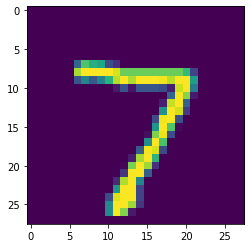

In [4]:
#predicting a single example from the test set
sample, label = dataset2[0]
out = model(sample.unsqueeze(0).cuda())
pred_label = torch.max(out, dim=1)[1].view([-1]).item()
print('The sample with true label {} was predicted with label {}'.format(label, pred_label))
plt.imshow(sample[0])